In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import music21
import chant21
import scipy
from scipy.fftpack import fft, dct, idct
from sklearn.decomposition import PCA

## Conversion code

In [2]:
_VOLPIANO_TO_MIDI = {
    "8": 53, # F
    "9": 55, # G
    "a": 57,
    "y": 58, # B flat
    "b": 59,
    "c": 60,
    "d": 62,
    "w": 63, # E flat
    "e": 64,
    "f": 65,
    "g": 67,
    "h": 69,
    "i": 70, # B flat
    "j": 71,
    "k": 72, # C
    "l": 74,
    "x": 75, # E flat
    "m": 76,
    "n": 77,
    "o": 79,
    "p": 81,
    "z": 82, # B flat
    "q": 83, # B
    "r": 84, # C
    "s": 86,
    
    # Liquescents
    "(": 53,
    ")": 55,
    "A": 57,
    "B": 59,
    "C": 60,
    "D": 62,
    "E": 64,
    "F": 65,
    "G": 67,
    "H": 69,
    "J": 71,
    "K": 72, # C
    "L": 74,
    "M": 76,
    "N": 77,
    "O": 79,
    "P": 81,
    "Q": 83,
    "R": 84, # C
    "S": 86, # D
    
    # Naturals
    "Y": 59, # Natural at B
    "W": 64, # Natural at E
    "I": 71, # Natural at B
    "X": 76, # Natural at E
    "Z": 83,
}

def volpiano_to_midi(volpiano, fill_na=False, skip_accidentals=False):
    """
    Translates volpiano pitches to a list of midi pitches

    All non-note characters are ignored or filled with `None`, if `fill_na=True`
    Unless `skip_accidentals=True`, accidentals are converted to midi pitches
    as well. So an i (flat at the B) becomes 70, a B flat. Or a W (a natural at
    the E) becomes 64 (E).
    """
    accidentals = 'iwxyz' + 'IWXYZ'
    midi = []
    for char in volpiano:
        if skip_accidentals and char in accidentals:
            pass
        elif char in _VOLPIANO_TO_MIDI:
            midi.append(_VOLPIANO_TO_MIDI[char])
        elif fill_na:
            midi.append(None)
    return midi

In [3]:
def volpiano_to_contour(volpiano, num_samples=50):
    pitches = volpiano_to_midi(volpiano + volpiano[-1])
    xs = np.linspace(0, 1, len(pitches))
    func = scipy.interpolate.interp1d(xs, pitches, kind='previous')
    return func(np.linspace(0, 1, num_samples))

In [4]:
def convert_segments(volpiano, normalize=False, num_samples=50):
    segments = volpiano.split()
    contours = np.asarray([
        volpiano_to_contour(s, num_samples=num_samples) 
        for s in segments])
    if normalize:
        contours = contours - contours.mean(axis=1)[:, np.newaxis]
    return contours

## Generate datasets

In [5]:
def generate_dataset(run, genre, subset, kind, segmentation, 
                     projection='cos',
                     num_chants=-1, dim=20, output_fn=None):
    # Load data
    chants = pd.read_csv(
        f'../datasets/cornelissen-etal-2020/{run}/{genre}/{subset}/{kind}-representation-pitch.csv', 
        index_col=0)
    chants = chants[segmentation].iloc[:num_chants]
    contours = chants.map(convert_segments)

    if projection == 'cos':
        proj = contours.map(lambda c: dct(c, norm='ortho')[:, 1:dim+1])
        basis = dct(np.eye(contours[0].shape[1]), norm="ortho")[:, 1:dim+1].T
    elif projection == 'pca':
        # Center contours for PCA
        contours = contours.map(lambda c: c-c.mean(axis=1)[:, np.newaxis])
        all_contours = np.concatenate(contours.values)
        pca = PCA(n_components=dim)
        pca.fit(all_contours)
        proj = contours.map(lambda c: pca.transform(c))
        basis = pca.components_
        
    # Store in HDF data store
    # Store as half precision floats
    proj = proj.map(lambda c: c.astype(np.float16))
    key = f'{genre}_{subset}_{kind}_{segmentation}_{projection}'
    output_fn = f'../data/mode-classification/{run}.h5' if output_fn is None else output_fn
    proj.to_hdf(output_fn, key=key, encoding='UTF-8', mode='a')
    print(f'Stored contours to {key}')
    
    basis_df = pd.DataFrame(basis).astype(np.float16)
    basis_df.to_hdf(output_fn, key=f'{key}_basis', encoding='UTF-8', mode='a')
    print(f'Stored basis to {key}_basis')
    
    return proj, basis, contours

df, basis, contours = generate_dataset('run-0', 'responsory', 'full', 'train', 
                                       'syllables', projection='pca', num_chants=50, 
                                       output_fn='../data/mode-classification/test.h5')

Stored contours to responsory_full_train_syllables_pca
Stored basis to responsory_full_train_syllables_pca_basis


/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/pandas/core/generic.py:2621: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  encoding=encoding,


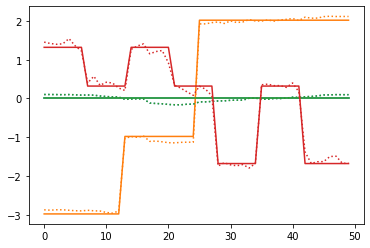

In [6]:
# To check if this work, we plot the construction and original contour
for i in range(4):
    chant = contours[0] - contours[0].mean(axis=1)[:, np.newaxis]
    plt.plot(chant[i, :].T, c=f'C{i}')
    plt.plot(df[0].dot(basis)[i, :].T, ':', c=f'C{i}')

In [ ]:
# Generate all datasets
refresh = False
for run in ['run-0', 'run-1', 'run-2']:
    store = pd.HDFStore(f'../data/mode-classification/{run}.h5')
    for genre in ['responsory', 'antiphon']:
        for subset in ['subset', 'full']:
            for kind in ['train', 'test']:
                for projection in ['cos', 'pca']:
                    for segmentation in ['words', 'syllables', 'neumes']:
                        key = f'/{genre}_{subset}_{kind}_{segmentation}_{projection}'
                        if key in store.keys() and refresh is False:
                            print('Already exists:', key)
                        else:
                            generate_dataset(
                                run=run,
                                genre=genre,
                                subset=subset,
                                kind=kind, 
                                segmentation=segmentation,
                                projection=projection,
                                num_chants=-1)